In [ ]:

from FeGdSpinGNN.FeGd_dataset import FeGdMagneticDataset
from FeGdSpinGNN.augmentation import RandomRotationTransform


#Code to load in the data with system indices for train, val, test splits
rotation_transform = RandomRotationTransform
cutoff_distance = 0.3

dataset_train = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[2, 3, 4, 5],
        cutoff_dist=cutoff_distance,  
        use_static_features=False,
        transform_rotate=rotation_transform 
    )

dataset_val = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[6, 7],
        cutoff_dist=cutoff_distance,  
        use_static_features=False,  
    )

dataset_test = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[8, 9],
        cutoff_dist=cutoff_distance,  
        use_static_features=False,  
    )

# Apply to loaded datasets
dataset_test[0]

Loading systems: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


Data(x=[800, 5], edge_index=[2, 9424], edge_attr=[9424, 4], y=[800, 3], pos=[800, 3], system_id=8, timestep=0)

In [1]:
import torch
from torch.utils.data import random_split
from FeGdSpinGNN.FeGd_dataset import FeGdMagneticDataset
from FeGdSpinGNN.augmentation import RandomRotationTransform

rotation_transform = RandomRotationTransform
cutoff_distance = 0.25


dataset_tot = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[2, 3, 4, 5, 6, 7, 8, 9],
        cutoff_dist=cutoff_distance,  
        use_static_features=False,
        transform_rotate=rotation_transform  
    )

n_total = len(dataset_tot)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

dataset_train, dataset_val, dataset_test = random_split(
    dataset_tot,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)



Loading systems: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


In [2]:
from FeGdSpinGNN.utils import compute_normalization_stats, normalize_data

# stats = compute_normalization_stats(dataset_train)
# train_normalized = [normalize_data(data, stats) for data in dataset_train]
# val_normalized = [normalize_data(data, stats) for data in dataset_val]
# test_normalized = [normalize_data(data, stats) for data in dataset_test]

In [2]:
from FeGdSpinGNN_NonEqui.FeGd_normalizer import FeGdNormalizer

normalizer = FeGdNormalizer().fit(dataset_train)

train_normalized = [normalizer.normalize(data) for data in dataset_train]
val_normalized = [normalizer.normalize(data) for data in dataset_val]
test_normalized = [normalizer.normalize(data) for data in dataset_test]

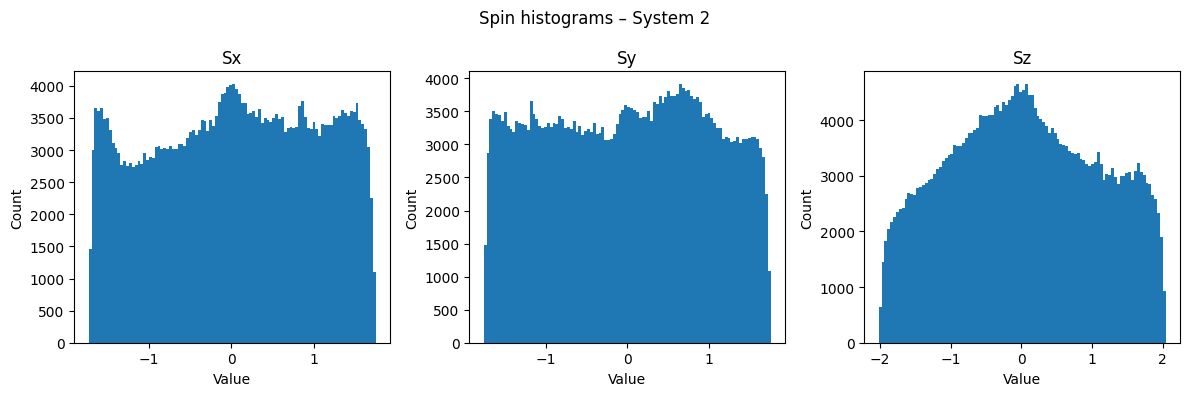

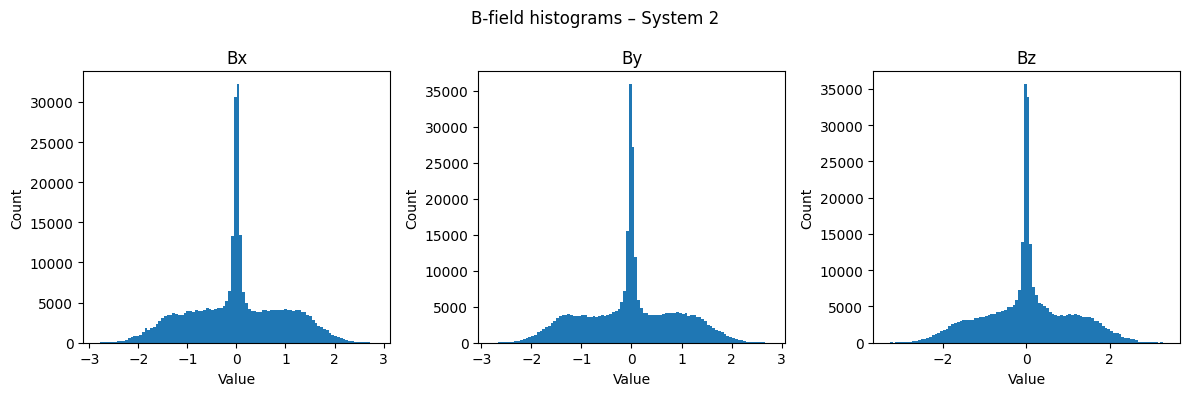

In [3]:
from FeGdSpinGNN_NonEqui.common.utils import plot_spin_B_histograms
plot_spin_B_histograms(train_normalized, systems=[2], bins=100)

In [4]:
from torch_geometric.loader import DataLoader
batch_size = 16

train_loader = DataLoader(train_normalized, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_normalized, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_normalized, batch_size=batch_size, shuffle=False)

In [13]:
import torch
import torch.optim as optim
from FeGdSpinGNN_NonEqui.models.InvariantFeGdFieldModel import InvariantFeGdBFieldModel
from FeGdSpinGNN_NonEqui.models.baseline_gnn import NaiveFeGdBFieldModel
import torch.nn as nn

# Initialize model
model = NaiveFeGdBFieldModel(
    node_in_dim=5,      
    hidden_dim=32,     
    num_layers=2,       
    dropout=0.2         
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

#Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    patience=10,
    factor=0.5,
    min_lr=1e-6
)

In [14]:
from FeGdSpinGNN_NonEqui.FeGd_trainer import mse_loss, BFieldTrainer

trainer = BFieldTrainer(
    model=model,
    device=device,
    optimizer=optimizer,
    scheduler=scheduler,
    lambda_angle=2.0,  
)

In [15]:
history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=3,
)

Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch   1/3 | Train loss 1.673763 | Val loss 1.273661 | MSE 0.597237 | Angle 39.71° | |B| MAE 1.101525 | 


Epoch   2/3 | Train loss 1.046652 | Val loss 0.896559 | MSE 0.271406 | Angle 37.84° | |B| MAE 0.527803 | 


Epoch   3/3 | Train loss 0.886937 | Val loss 0.786558 | MSE 0.242091 | Angle 34.99° | |B| MAE 0.466654 | 


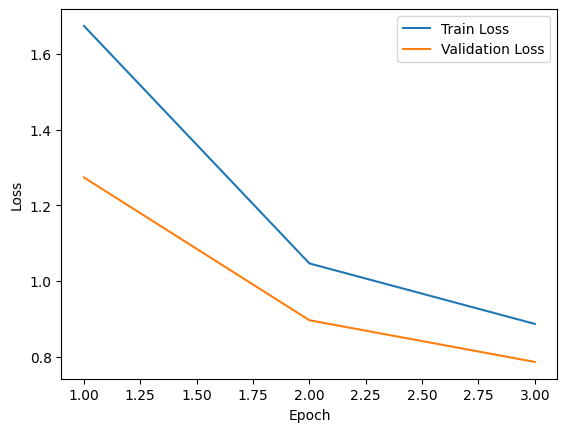

In [16]:
from FeGdSpinGNN_NonEqui.common.utils import plot_correlation, training_plot, plot_true_pred_B_fields
training_plot(num_epochs=len(history['train_loss']), train_losses=history['train_loss'], val_losses=history['val_loss'])

In [9]:
# Evaluate on test set
_, _, test_mse, _ = trainer.evaluate(test_loader)
print(f"Test MSE Loss: {test_mse:.6f}")


Test MSE Loss: 0.214468


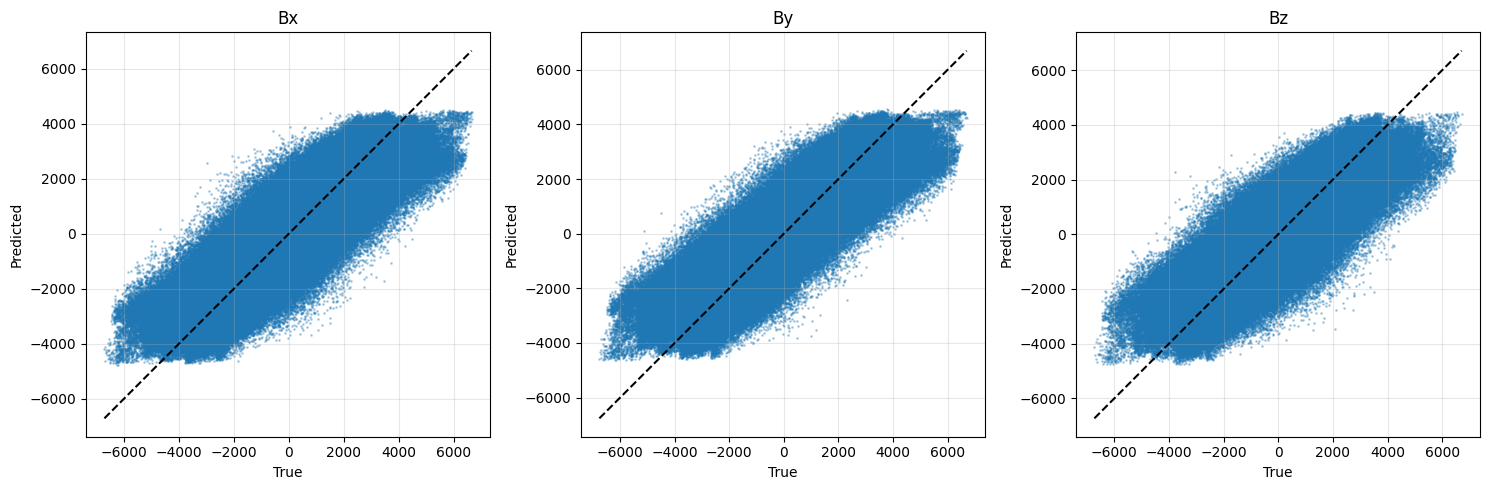

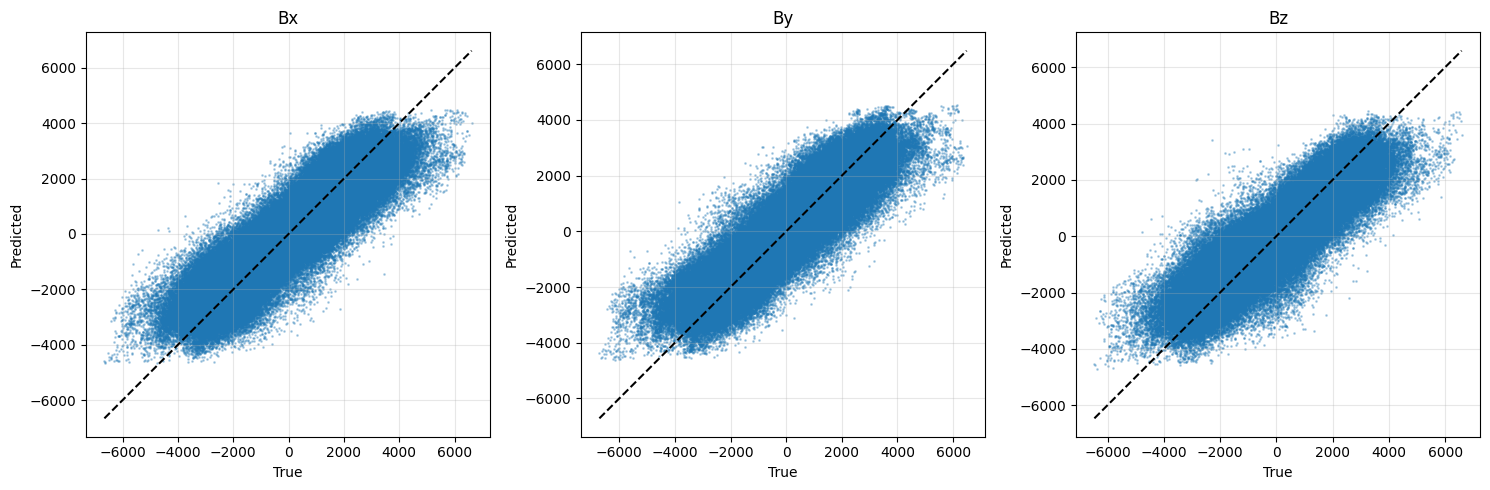

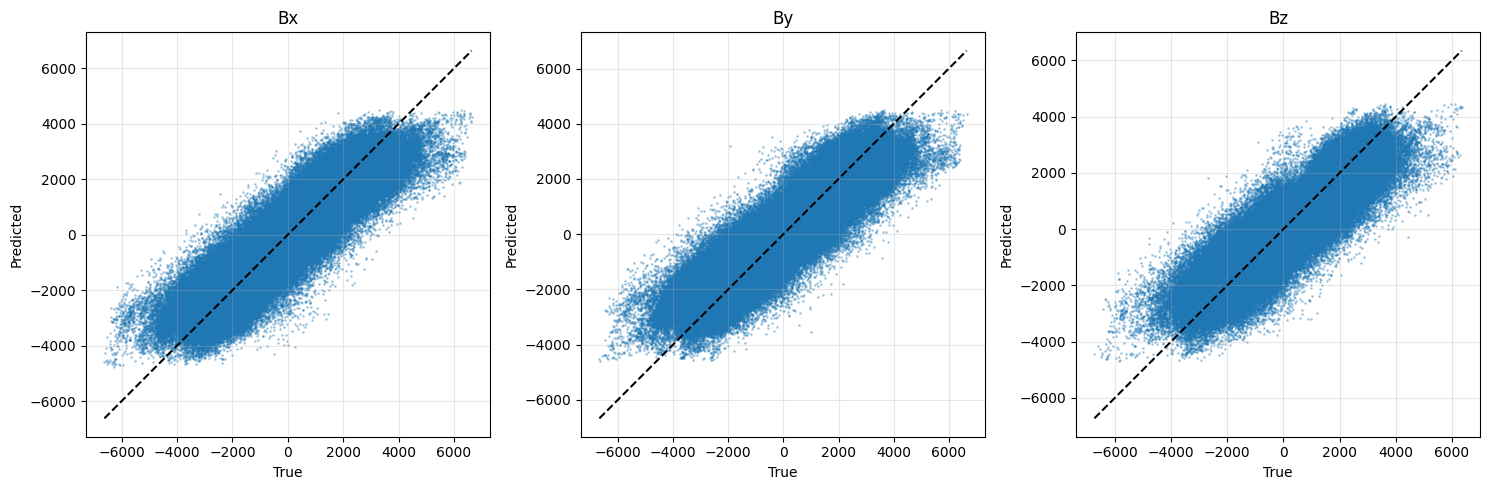

In [10]:
plot_correlation(model, train_loader, device, normalizer=normalizer)
plot_correlation(model, val_loader, device, normalizer=normalizer)
plot_correlation(model, test_loader, device, normalizer=normalizer)

In [11]:
from FeGdSpinGNN_NonEqui.common.utils import evaluate_physical_metrics

test_metrics = evaluate_physical_metrics(
    model,
    test_loader,
    device,
    normalizer
)

print("\nTest Set Metrics (Physical Units):")
print(f"  MSE:  {test_metrics['mse']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"  MAE:  {test_metrics['mae']:.6f}")
print(
    f"  MSE (Bx, By, Bz): "
    f"{test_metrics['mse_x']:.6f}, "
    f"{test_metrics['mse_y']:.6f}, "
    f"{test_metrics['mse_z']:.6f}"
)

val_metrics = evaluate_physical_metrics(
    model,
    val_loader,
    device,
    normalizer
)
print("\nVal Set Metrics (Physical Units):")
print(f"  MSE:  {val_metrics['mse']:.6f}")
print(f"  RMSE: {val_metrics['rmse']:.6f}")
print(f"  MAE:  {val_metrics['mae']:.6f}")
print(
    f"  MSE (Bx, By, Bz): "
    f"{val_metrics['mse_x']:.6f}, "
    f"{val_metrics['mse_y']:.6f}, "
    f"{val_metrics['mse_z']:.6f}"
)

train_metrics = evaluate_physical_metrics(
    model,
    train_loader,
    device,
    normalizer
)

print("\nTrain Set Metrics (Physical Units):")
print(f"  MSE:  {train_metrics['mse']:.6f}")
print(f"  RMSE: {train_metrics['rmse']:.6f}")
print(f"  MAE:  {train_metrics['mae']:.6f}")
print(
    f"  MSE (Bx, By, Bz): "
    f"{train_metrics['mse_x']:.6f}, "
    f"{train_metrics['mse_y']:.6f}, "
    f"{train_metrics['mse_z']:.6f}"
)


Test Set Metrics (Physical Units):
  MSE:  597480.312500
  RMSE: 772.968506
  MAE:  575.779968
  MSE (Bx, By, Bz): 600058.500000, 624794.375000, 567588.187500

Val Set Metrics (Physical Units):
  MSE:  591556.562500
  RMSE: 769.127136
  MAE:  569.957642
  MSE (Bx, By, Bz): 625845.062500, 576617.375000, 572207.312500

Train Set Metrics (Physical Units):
  MSE:  587078.437500
  RMSE: 766.210449
  MAE:  569.617432
  MSE (Bx, By, Bz): 601849.937500, 595852.437500, 563532.875000


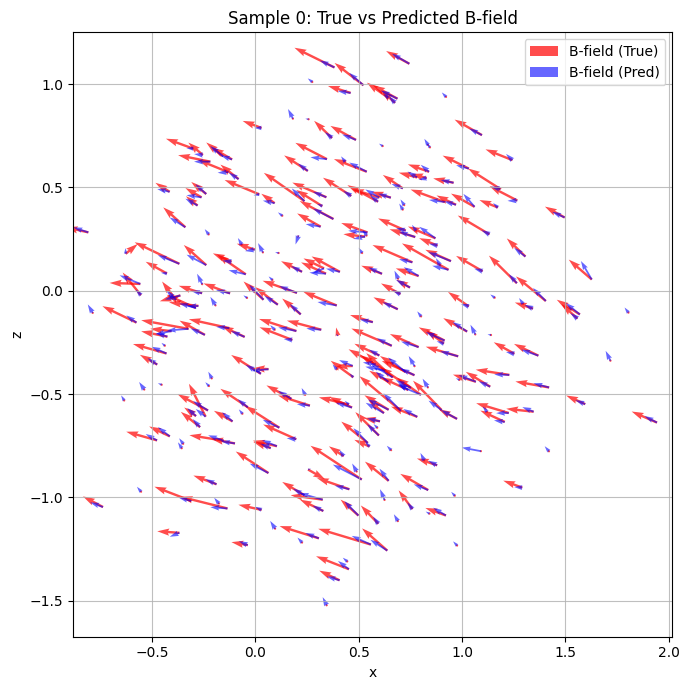

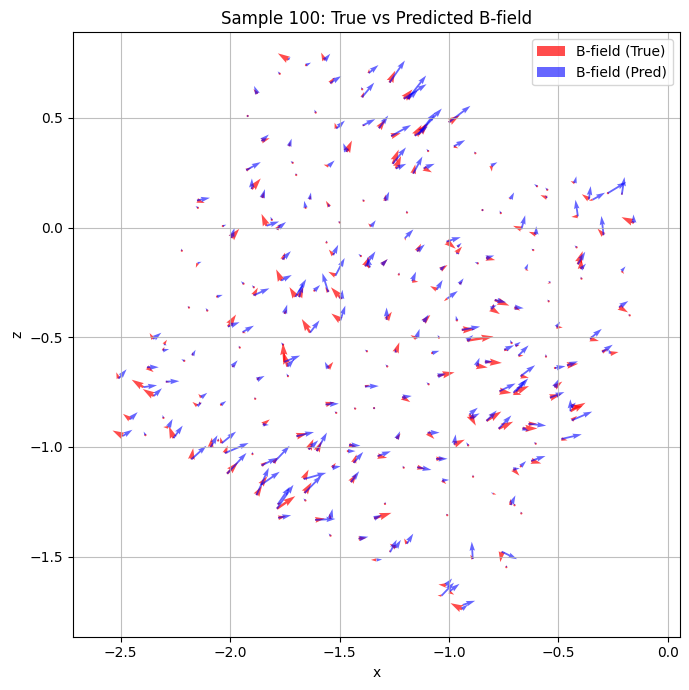

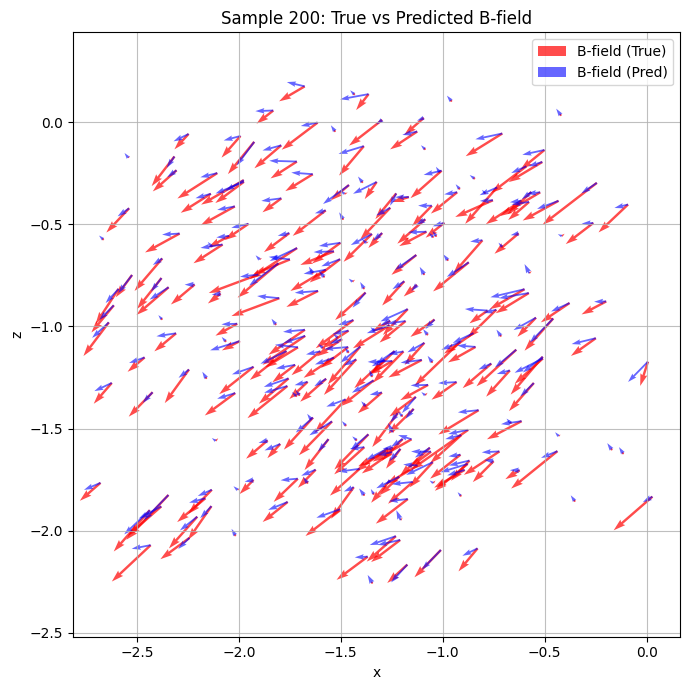

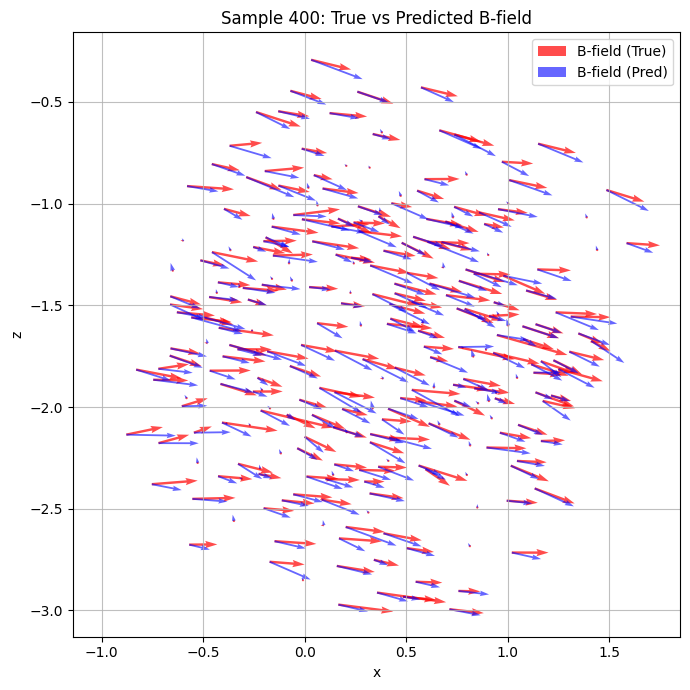

In [17]:
test_indices = [0, 100, 200, 400]#, 400]
plot_true_pred_B_fields(model, test_normalized, test_indices,
                       normalizer, scale_B=50000, device=device)